<a href="https://colab.research.google.com/github/kridtapon/Parabolic-SAR-ADX/blob/main/Parabolic_SAR%2BADX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Define the stock symbol and time period
symbol = 'NRG'  # Meta Platforms, Inc.
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Parabolic SAR
def calculate_parabolic_sar(df, af=0.02, max_af=0.2):
    high, low = df['High'], df['Low']
    sar = low[0]
    ep = high[0]
    af_val = af
    long_position = True
    parabolic_sar = []

    for i in range(len(df)):
        if long_position:
            sar = sar + af_val * (ep - sar)
            sar = min(sar, low[i - 1]) if i > 0 else sar
            sar = min(sar, low[i - 2]) if i > 1 else sar
            if high[i] > ep:
                ep = high[i]
                af_val = min(af_val + af, max_af)
            if low[i] < sar:
                long_position = False
                sar = ep
                ep = low[i]
                af_val = af
        else:
            sar = sar + af_val * (ep - sar)
            sar = max(sar, high[i - 1]) if i > 0 else sar
            sar = max(sar, high[i - 2]) if i > 1 else sar
            if low[i] < ep:
                ep = low[i]
                af_val = min(af_val + af, max_af)
            if high[i] > sar:
                long_position = True
                sar = ep
                ep = high[i]
                af_val = af

        parabolic_sar.append(sar)
    return pd.Series(parabolic_sar, index=df.index)

# Add Parabolic SAR to the DataFrame
df['Parabolic_SAR'] = calculate_parabolic_sar(df,0.05,0.5)

# Calculate ADX (Average Directional Index)
def calculate_adx(df, period=14):
    high, low, close = df['High'], df['Low'], df['Close']
    tr = pd.Series(np.maximum.reduce([
        high - low,
        abs(high - close.shift()),
        abs(low - close.shift())
    ]), index=df.index)
    tr_smooth = tr.rolling(window=period).sum()

    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = -minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)

    plus_di = 100 * plus_dm.rolling(window=period).sum() / tr_smooth
    minus_di = 100 * minus_dm.rolling(window=period).sum() / tr_smooth
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()

    return adx

# Add ADX to the DataFrame
df['ADX'] = calculate_adx(df,8)

# Define Entry and Exit signals based on Parabolic SAR and ADX
df['Entry'] = (df['Close'] > df['Parabolic_SAR']) & (df['ADX'] > 25)
df['Exit'] = (df['Close'] < df['Parabolic_SAR']) & (df['ADX'] > 25)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-8d5fd1d9fb5b>:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-13-8d5fd1d9fb5b>:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-13-8d5fd1d9fb5b>:30: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-13-8d5fd1d9fb5b>:33: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a fut

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           413568.093279
Total Return [%]                       313.568093
Benchmark Return [%]                   175.103187
Max Gross Exposure [%]                      100.0
Total Fees Paid                      22111.155801
Max Drawdown [%]                        27.632923
Max Drawdown Duration                       195.0
Total Trades                                   46
Total Closed Trades                            45
Total Open Trades                               1
Open Trade PnL                       -9682.483577
Win Rate [%]                            57.777778
Best Trade [%]                          28.383635
Worst Trade [%]                         -9.513929
Avg Winning Trade [%]                    8.926791
Avg Losing Trade [%]                    -3.729393


Streaming output truncated to the last 5000 lines.
<ipython-input-12-87305c6a364f>:51: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-87305c6a364f>:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-87305c6a364f>:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-87305c6a364f>:34: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

       af  max_af  adx_period  total_return
627  0.05     0.5           8    313.568093
601  0.05     0.4           8    313.568093
544  0.05     0.1          29    294.329233
575  0.05     0.3           8    285.896471
560  0.05     0.2          19    252.738060
Best Parameters: af=0.05, max_af=0.5, adx_period=8.0


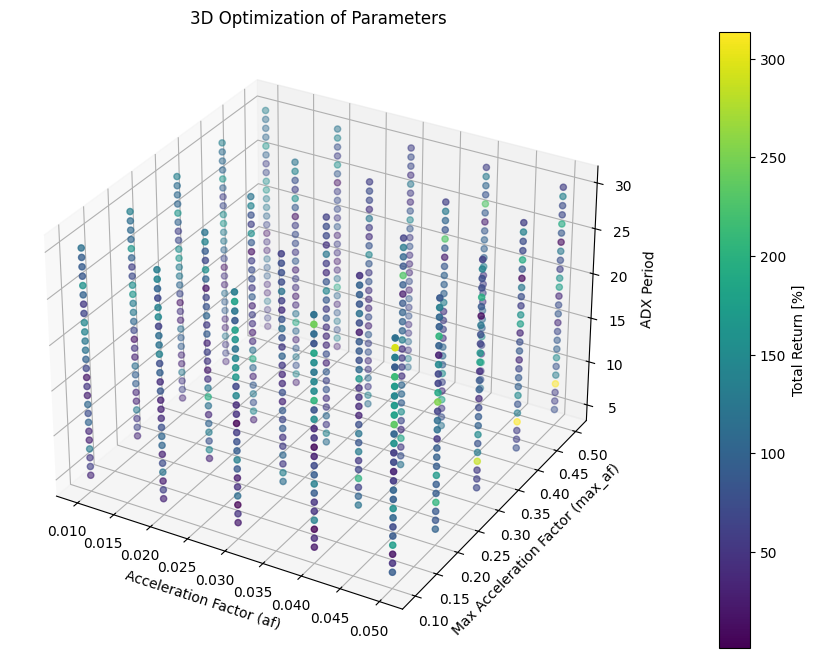

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the stock symbol and time period
symbol = 'NRG'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Function to calculate Parabolic SAR
def calculate_parabolic_sar(df, af=0.02, max_af=0.2):
    high, low = df['High'], df['Low']
    sar = low[0]
    ep = high[0]
    af_val = af
    long_position = True
    parabolic_sar = []

    for i in range(len(df)):
        if long_position:
            sar = sar + af_val * (ep - sar)
            sar = min(sar, low[i - 1]) if i > 0 else sar
            sar = min(sar, low[i - 2]) if i > 1 else sar
            if high[i] > ep:
                ep = high[i]
                af_val = min(af_val + af, max_af)
            if low[i] < sar:
                long_position = False
                sar = ep
                ep = low[i]
                af_val = af
        else:
            sar = sar + af_val * (ep - sar)
            sar = max(sar, high[i - 1]) if i > 0 else sar
            sar = max(sar, high[i - 2]) if i > 1 else sar
            if low[i] < ep:
                ep = low[i]
                af_val = min(af_val + af, max_af)
            if high[i] > sar:
                long_position = True
                sar = ep
                ep = high[i]
                af_val = af

        parabolic_sar.append(sar)
    return pd.Series(parabolic_sar, index=df.index)

# Function to calculate ADX
def calculate_adx(df, period=14):
    high, low, close = df['High'], df['Low'], df['Close']
    tr = pd.Series(np.maximum.reduce([
        high - low,
        abs(high - close.shift()),
        abs(low - close.shift())
    ]), index=df.index)
    tr_smooth = tr.rolling(window=period).sum()

    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = -minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)

    plus_di = 100 * plus_dm.rolling(window=period).sum() / tr_smooth
    minus_di = 100 * minus_dm.rolling(window=period).sum() / tr_smooth
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()

    return adx

# Parameter grid
af_values = [0.01, 0.02, 0.03, 0.04, 0.05]
max_af_values = [0.1, 0.2, 0.3, 0.4, 0.5]
adx_periods = range(5, 31)

# Optimization loop
results = []
for af, max_af, period in product(af_values, max_af_values, adx_periods):
    df['Parabolic_SAR'] = calculate_parabolic_sar(df, af=af, max_af=max_af)
    df['ADX'] = calculate_adx(df, period=period)
    df['Entry'] = (df['Close'] > df['Parabolic_SAR']) & (df['ADX'] > 25)
    df['Exit'] = (df['Close'] < df['Parabolic_SAR']) & (df['ADX'] > 25)

    # Filter data for the test period (2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Collect performance metrics
    stats = portfolio.stats()
    results.append({
        'af': af,
        'max_af': max_af,
        'adx_period': period,
        'total_return': stats['Total Return [%]']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by best Sharpe Ratio or Total Return
optimized_results = results_df.sort_values(by='total_return', ascending=False)
print(optimized_results.head())

# Best parameters
best_params = optimized_results.iloc[0]
print(f"Best Parameters: af={best_params['af']}, max_af={best_params['max_af']}, adx_period={best_params['adx_period']}")

# Prepare data for 3D plotting
af_values_plot = results_df['af']
max_af_values_plot = results_df['max_af']
adx_periods_plot = results_df['adx_period']
total_returns_plot = results_df['total_return']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    af_values_plot,
    max_af_values_plot,
    adx_periods_plot,
    c=total_returns_plot,
    cmap='viridis',
    marker='o'
)

# Add color bar for the total return
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Total Return [%]')

# Set axis labels
ax.set_xlabel('Acceleration Factor (af)')
ax.set_ylabel('Max Acceleration Factor (max_af)')
ax.set_zlabel('ADX Period')
ax.set_title('3D Optimization of Parameters')

plt.show()


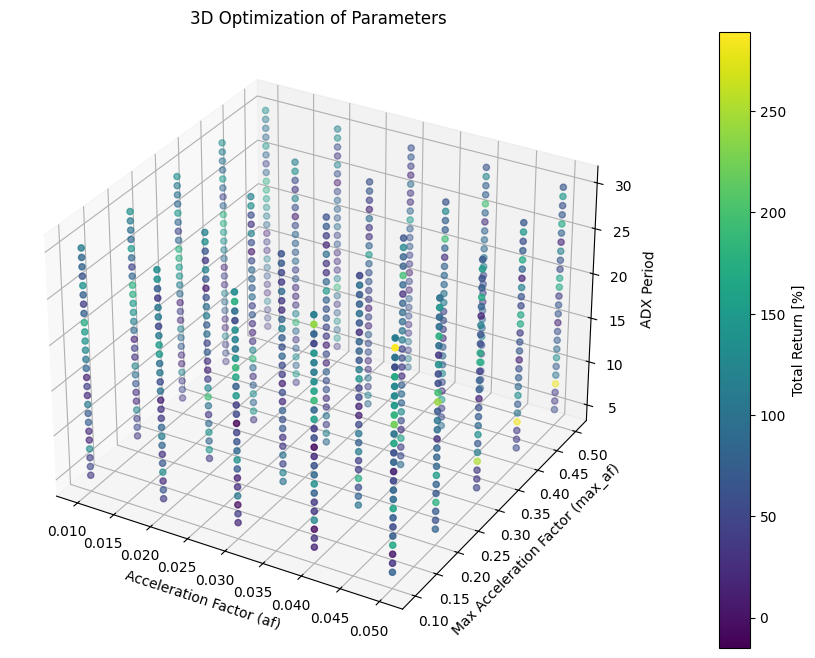

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D plotting
af_values_plot = results_df['af']
max_af_values_plot = results_df['max_af']
adx_periods_plot = results_df['adx_period']
total_returns_plot = results_df['total_return']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    af_values_plot,
    max_af_values_plot,
    adx_periods_plot,
    c=total_returns_plot,
    cmap='viridis',
    marker='o'
)

# Add color bar for the total return
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Total Return [%]')

# Set axis labels
ax.set_xlabel('Acceleration Factor (af)')
ax.set_ylabel('Max Acceleration Factor (max_af)')
ax.set_zlabel('ADX Period')
ax.set_title('3D Optimization of Parameters')

plt.show()
